In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm_notebook as tqdm
import copy

from mbptycho.code.simulation import reloadSimulation
from skimage.feature import register_translation
from scipy import io
from mbptycho.code.recons.recons import DisplacementProjectedReconstruction

import os
base_path = os.environ['HOME']

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[0:1], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


cmap = copy.copy(mpl.cm.get_cmap('coolwarm'))
cmap.set_bad('black')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
strain_type = 'point_inclusion'
data_path =  f'{base_path}/code/mbptycho/experiments/python/{strain_type}_sparse/weak_peaks/'
sim_data_path = f'{data_path}/sim_{strain_type}.pkl'
sample_data_path = f'{data_path}/sample_{strain_type}.pkl'

save_plots = False

In [4]:
sm = reloadSimulation(sim_data_path, reload_sim=True)#sim_params={"HKL_list":[[1, 2, 0]]}
sm.sample.Ux_trunc.shape, sm.sample.params.sample_pix_size

File exists. Reloading...


((200, 200, 20), 0.005841818181818182)

# Reconstruction

In [5]:
recons = DisplacementProjectedReconstruction(simulation=sm)

Setting background_level to 1e-08...


In [61]:
recons.optimizers = {}

In [62]:
phases_lr = 1e-1
magnitude_lr = 1e-1
if not 'phases_v' in recons.optimizers:
    recons.setPhaseAdamOptimizer(phases_lr)
else:
    recons.optimizers['phases_v']['learning_rate'].assign(phases_lr)

if not 'magnitudes_log_v' in recons.optimizers:
    recons.setMagnitudeLogAdamOptimizer(magnitude_lr)
else:
    recons.optimizers['magnitudes_log_v']['learning_rate'].assign(magnitude_lr)

recons.optimizers

{'phases_v': {'learning_rate': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>,
  'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x7ff09024cf70>,
  'var': <tf.Variable 'phases:0' shape=(69825,) dtype=float32, numpy=
  array([13.351772 , 13.351772 , 13.351772 , ...,  2.3562305,  2.3562305,
          2.3562305], dtype=float32)>},
 'magnitudes_log_v': {'learning_rate': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>,
  'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x7ff09024c7c0>,
  'var': <tf.Variable 'magnitudes_log_v:0' shape=(13969,) dtype=float32, numpy=
  array([ 0.       ,  0.       ,  0.       , ..., -1.2990352, -1.617592 ,
         -1.23771  ], dtype=float32)>}}

In [72]:
recons.minimize(500)

           epoch  train_loss     err_ux     err_uy  err_ux_film  err_uy_film   err_rho0   err_rho1   err_rho2   err_rho3   err_rho4  err_rho_film0  err_rho_film1  err_rho_film2  err_rho_film3  err_rho_film4
13648   1.72e+03    3.88e+03       0.57       0.38        0.392         0.12      0.949      0.955      0.963      0.955      0.954           0.16          0.163          0.205          0.186          0.218
13656   1.72e+03   3.71e+03      0.574      0.381      0.393      0.121      0.949      0.955      0.963      0.955      0.954       0.16      0.164      0.205      0.187      0.218
13664   1.72e+03   3.97e+03      0.576      0.378      0.394      0.123      0.949      0.955      0.963      0.955      0.954      0.159      0.163      0.204      0.185      0.219
13672   1.72e+03    3.8e+03      0.574      0.374        0.4      0.119      0.949      0.955      0.963      0.955      0.954       0.16      0.163      0.204      0.186       0.22
13680   1.72e+03   3.76e+03      0.572  

KeyboardInterrupt: 

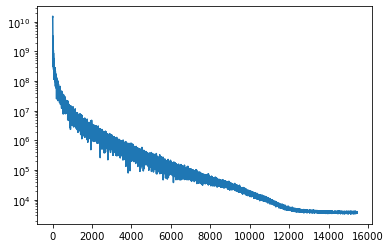

In [73]:
plt.plot(recons.datalog.dataframe.train_loss.dropna())
plt.yscale('log')

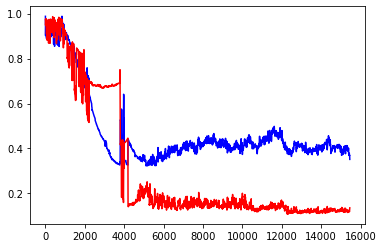

In [74]:
plt.plot(recons.datalog.dataframe.err_ux_film.dropna(), color='blue')
plt.plot(recons.datalog.dataframe.err_uy_film.dropna(), color='red')
#plt.yscale('log')

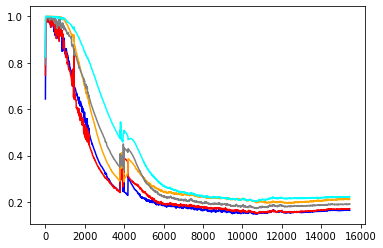

In [75]:
plt.plot(recons.datalog.dataframe.err_rho_film0.dropna(), color='blue')
plt.plot(recons.datalog.dataframe.err_rho_film1.dropna(), color='red')
plt.plot(recons.datalog.dataframe.err_rho_film2.dropna(), color='orange')
plt.plot(recons.datalog.dataframe.err_rho_film3.dropna(), color='gray')
plt.plot(recons.datalog.dataframe.err_rho_film4.dropna(), color='cyan')

In [76]:

true_items = {}
recons_items = {}

if recons._model_type != 'phase':
    recons_items[r"$\alpha_x$"] = recons.ux_2d - recons.ux_2d.mean() 
    true_items[r"$\alpha_x$"] = recons._ux_true - recons._ux_true.mean() 

    recons_items[r"$\alpha_y$"] = recons.uy_2d - recons.uy_2d.mean()
    true_items[r"$\alpha_y$"] = recons._uy_true - recons._uy_true.mean()


if not recons._model_type == 'displacement_to_phase':

    for i in range(recons.rho_2d.shape[0]):
        phase_label = ''.join(sm.params.HKL_list[i].astype('str'))
        labelstr = rf"$\phi$({phase_label})"
        
        rollr, errr, phaser = register_translation( recons._rho_true[i], recons.rho_2d[i], upsample_factor=10)
        recons_items[labelstr] = np.angle(recons.rho_2d[i] * np.exp(1j * phaser))
        true_items[labelstr] = np.angle(recons._rho_true[i])

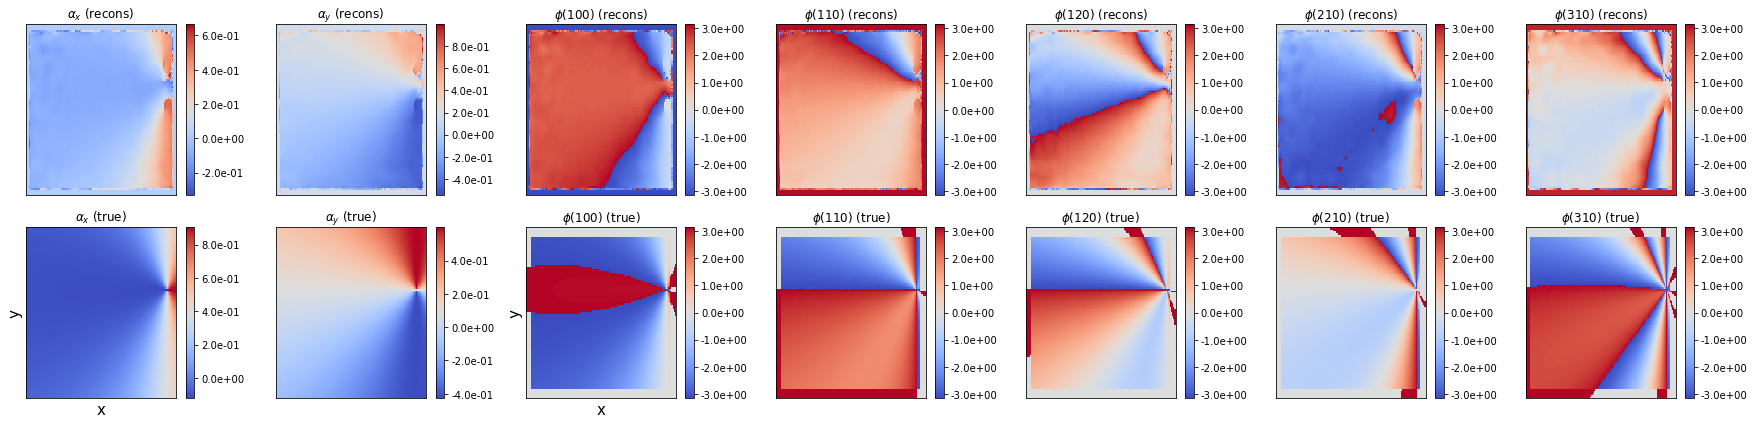

In [77]:
save_plots = False
if recons._model_type == 'phase':
    subplots_x = recons.rho_2d.shape[0] 
    figsize_x = subplots_x * 3.5
elif recons._model_type == 'displacement_to_phase':
    figsize_x = 8
    subplots_x = 2
else:
    subplots_x = (recons.rho_2d.shape[0] + 2) 
    figsize_x = subplots_x * 3.5

recons_suffix = recons._model_type

    
fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 
for i, (key, value) in enumerate(recons_items.items()):
    if i == 0 and recons._model_type != 'phase':
        vmin=-2.1
        vmax = 2.1
    elif i == 1 and recons._model_type!= 'phase':
        vmin = -0.21
        vmax = 0.21
    else:
        vmin = -np.pi
        vmax = np.pi
    
    #value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp0 = axs[0, i].pcolormesh(value, cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[0, i].set_title(key + " (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%2.1e")
    
    true_value = true_items[key] 
    #true_value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp1 = axs[1, i].pcolormesh(true_items[key], cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[1, i].set_title(key + " (true)")
    plt.colorbar(cp1, ax=axs[1, i], format="%2.1e")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

if not recons._model_type=='displacement_to_phase':
    axs[1,2].set_xlabel('x', fontsize=15)
    axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()

if save_plots:
    
    plt.savefig(f'{data_path}_recons_{recons_suffix}.png', bbox_inches='tight')
plt.show()

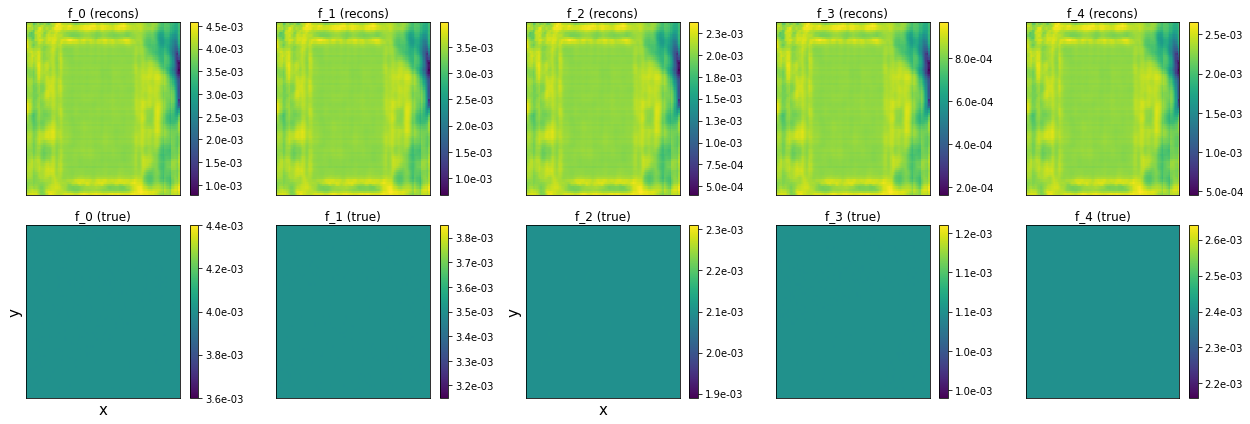

In [78]:
subplots_x = recons.rho_2d.shape[0] 
figsize_x = subplots_x * 3.5

fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 

for i in range(recons.rho_2d.shape[0]):
    recons_amplitudes = np.abs(recons.rho_2d[i][10:-10,10:-10])
    true_amplitudes = np.abs(recons._rho_true[i][10:-10,10:-10])
    
    cp0 = axs[0, i].pcolormesh(recons_amplitudes)
    axs[0, i].set_title(f"f_{i} (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%.1e")
    
    cp1 = axs[1, i].pcolormesh(true_amplitudes)
    axs[1, i].set_title(f"f_{i} (true)")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    plt.colorbar(cp1, ax=axs[1, i], format="%.1e")
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

axs[1,2].set_xlabel('x', fontsize=15)
axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}_recons_amplitudes.png', bbox_inches='tight')
plt.show()


In [79]:
sm.ptycho_scan_positions.shape

(81, 2)

In [80]:
recons.saveOutputsAndLog(data_path)

rhos saved in /raid/home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/extra_peaks/weak_peaks/rho_projected_shared_mags.npz
ux save in /raid/home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/extra_peaks/weak_peaks/ux_projected_shared_mags.npz
uy save in /raid/home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/extra_peaks/weak_peaks/uy_projected_shared_mags.npz
dataframe saved in /raid/home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/extra_peaks/weak_peaks/df_projected_shared_mags.gz


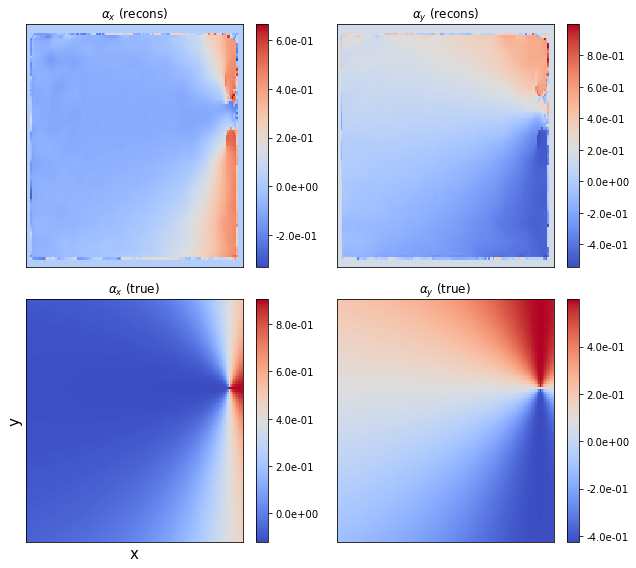

In [81]:
fig, axs = plt.subplots(2, 2, figsize=[9, 8]) 
for i, key in enumerate(['$\\alpha_x$', '$\\alpha_y$']):
    
    #value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp0 = axs[0, i].pcolormesh(recons_items[key], cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[0, i].set_title(key + " (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%2.1e")
    
    true_value = true_items[key] 
    #true_value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp1 = axs[1, i].pcolormesh(true_items[key], cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[1, i].set_title(key + " (true)")
    plt.colorbar(cp1, ax=axs[1, i], format="%2.1e")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)


plt.tight_layout()
plt.show()